## Definition

* In time series we have an explicit order dependence between observations: a time dimension
* The time dimension is both a constraint and a structure that provides a source of additional information

```
Time #1, observation
Time #2, observation
Time #3, observation
```


## Time Series Nomenclature

* Current time $t$, the observation at the current time is `obs(t)`
* Previos time is $(t-1)$
* The time before that is $(t-2)$
* ...
* The next time is $(t+1)$

To summarize:
* $t - n$: A prior or lag time
* $t$: a current time and point of reference
* $t+n$: a future or forecast time

### Daily Female Births Dataset

We will use [this dataset](https://www.kaggle.com/datasets/dougcresswell/daily-total-female-births-in-california-1959])

https://www.kaggle.com/datasets/paulbrabban/daily-minimum-temperatures-in-melbourne

In [1]:
import pandas as pd

series = pd.read_csv("data/daily-minimum-temperatures-in-me.csv", parse_dates=True)
type(series)

pandas.core.frame.DataFrame

# Time Series

## Learning outcomes
* Standard definitions of time series, time series analysis, and time series forecasting
* The important components to consider in time series data
* Some ways to visualize time series data
* Lag Features


## Bibliography

https://otexts.com/fpp3/

https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/

In [2]:
series.dtypes

Date                                                              object
Daily minimum temperatures in Melbourne, Australia, 1981-1990    float64
dtype: object

In [3]:
series['Date'] = pd.to_datetime(series['Date'])

In [4]:
series.dtypes

Date                                                             datetime64[ns]
Daily minimum temperatures in Melbourne, Australia, 1981-1990           float64
dtype: object

In [5]:
series.head()

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [6]:
# parsing dates while loading
url = 'https://raw.githubusercontent.com/gabrielalusofona/cda/main/lectures/data/daily-minimum-temperatures-in-me.csv'
series2 = pd.read_csv(url, parse_dates=[0])

In [7]:
series2.dtypes

Date                                                             datetime64[ns]
Daily minimum temperatures in Melbourne, Australia, 1981-1990           float64
dtype: object

<Axes: >

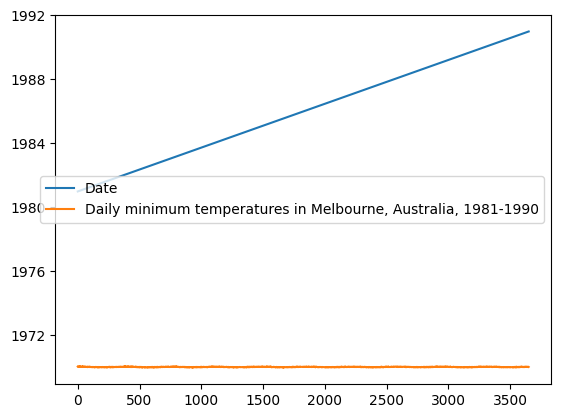

In [8]:
series.plot()

<Axes: xlabel='Date'>

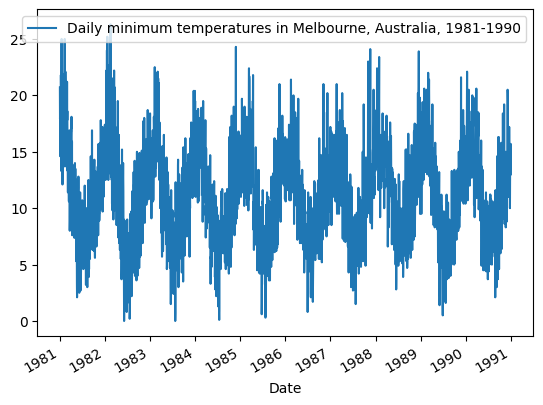

In [9]:
# ploting with datetime index
series.set_index('Date').plot()

In [10]:
series.set_index('Date', inplace=True)

In [11]:
series.columns = ['Temperature']

In [12]:
series.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [13]:
series2.columns = ['Date', 'Temperature']
series2.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [14]:
series.size

3650

In [15]:
series2.size

7300

In [16]:
series.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [17]:
series.isna().sum()

Temperature    0
dtype: int64

## Feature Engineering for Time Series

- What is feature engineering?
  - The computation of new features based on the data or in external concepts

- Question for you: what is the goal of feature engineering?
  - The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning

* Date Time Features: these are components of the time step itself for each observation.
* Lag Features: these are values at prior time steps.
* Window Features: these are a summary of values over a fixed window of prior time steps.

In [18]:
dataframe = pd.DataFrame()
dataframe['month'] = series2['Date'].dt.month
dataframe['day'] = series2['Date'].dt.day
dataframe['temperature'] = series2['Temperature']

In [19]:
dataframe.head()

,month,day,temperature
0,1,1,20.7
1,1,2,17.9
2,1,3,18.8
3,1,4,14.6
4,1,5,15.8


In [20]:
dataframe = pd.DataFrame()
dataframe['month'] = series.index.month
dataframe['day'] = series.index.day
dataframe['temperature'] = series['Temperature'].values

In [21]:
dataframe.head()

,month,day,temperature
0,1,1,20.7
1,1,2,17.9
2,1,3,18.8
3,1,4,14.6
4,1,5,15.8


Using just the month and day information alone to predict temperature is not sophisticated and will likely result in a poor model.
You may enumerate all the properties of a time-stamp and consider what might be useful for your problem, such as:
* Minutes elapsed for the day.
* Hour of day
* Business hours or not
* Weekend or not
* Season of the year
* Business quarter of the year
* Daylight savings or not
* Public holiday or not
* Leap year or not

See dt related functions in [Pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.html)

## Lag Features
* Classical way that time series forecasting problems are transformed into supervised learning problems.
* The simplest approach is to predict the value at the next time $(t+1)$ given the value at the current time ($t$)
* Pandas provides the `shift()` function to created shifted features to a time series dataset

In [22]:
series.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


We want to have the date field as an index

In [23]:
temps = pd.DataFrame(series.values)

dataframe = pd.concat([temps.shift(1), temps], axis=1)
dataframe.columns = ['t-1', 't']
dataframe.head()

,t-1,t
0,NaN,20.7
1,20.7,17.9
2,17.9,18.8
3,18.8,14.6
4,14.6,15.8


In [24]:
dataframe = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
dataframe.columns = ['t-3', 't-2', 't-1', 't']
dataframe.head()


,t-3,t-2,t-1,t
0,NaN,NaN,NaN,20.7
1,NaN,NaN,20.7,17.9
2,NaN,20.7,17.9,18.8
3,20.7,17.9,18.8,14.6
4,17.9,18.8,14.6,15.8


We can create a function to do the lagged features in the same dataframe:

In [25]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [26]:
series.columns

Index(['Temperature'], dtype='object')

In [27]:
series_lag5 = create_lag_df(series, 5, ['Temperature'])

In [28]:
series_lag5.head(5)

,Temperature,Temperature-1,Temperature-2,Temperature-3,Temperature-4,Temperature-5
Date,,,,,,
1981-01-01,20.7,NaN,NaN,NaN,NaN,NaN
1981-01-02,17.9,20.7,NaN,NaN,NaN,NaN
1981-01-03,18.8,17.9,20.7,NaN,NaN,NaN
1981-01-04,14.6,18.8,17.9,20.7,NaN,NaN
1981-01-05,15.8,14.6,18.8,17.9,20.7,NaN


## Describing x Predicting

### Time Series Analysis
* Uses classical statistical
* Develop models that best capture or describe an observed time series in order to understand the underlying causes
* Making assumptions about the form of the data and decomposing the time series into constitution components
* Primary objective: develop mathematical models that provide plausible descriptions from sample data



### Time Series Forecasting
* Predictions about the future = extrapolation (classical statistical)
* Modern fields: time series forecasting
* Taking models to fit on historical and using them to predict future observation
* Descriptive models can use data from the future, they only seek to best describe data
* For forecasting the futuro is completely unavailable

## Visualizations

<Axes: xlabel='Date'>

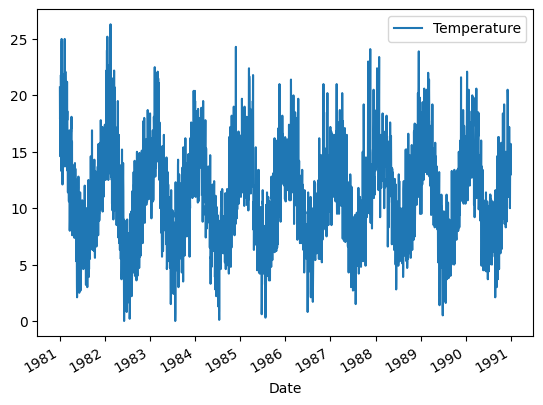

In [29]:
series.plot()

The line plot is quite dense.
We can change the style of the line.

<Axes: xlabel='Date'>

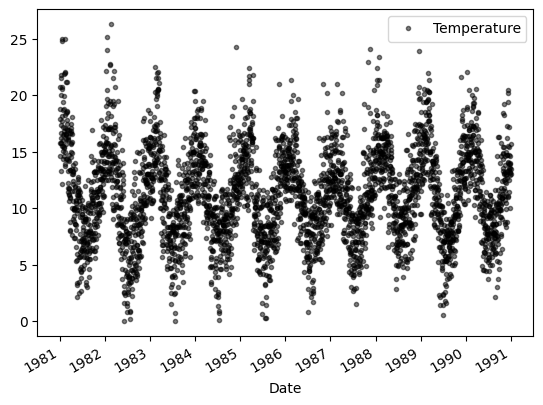

In [30]:
series.plot(style='k.', alpha=0.5)

Is the temperature changing over time?
We have 10 years information

How could we verify if we can see any changes over the years?

### Groupby

* It can be helpful to compare line plots for the same interval
    * day-to-day
    * month-to-month
    * year-to-year

The Daily Temperatures dataset spans 10 years
We can group data by year and create a line plot for each year for direct comparison

In [31]:
groups = series.groupby(pd.Grouper(freq='YE'))
years = pd.DataFrame()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

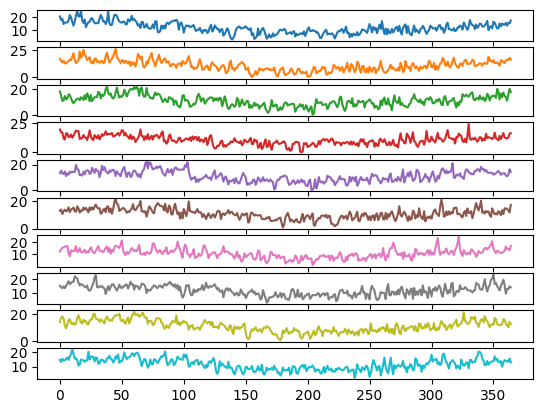

In [32]:
import numpy as np
for name, group in groups:
    years[name.year] = np.ravel(group.values.tolist())

years.plot(subplots=True, legend=False)

Not very informative...

Let's try different kinds of visualizations

### Histograms and Density Plots

array([[<Axes: title={'center': 'Temperature'}>]], dtype=object)

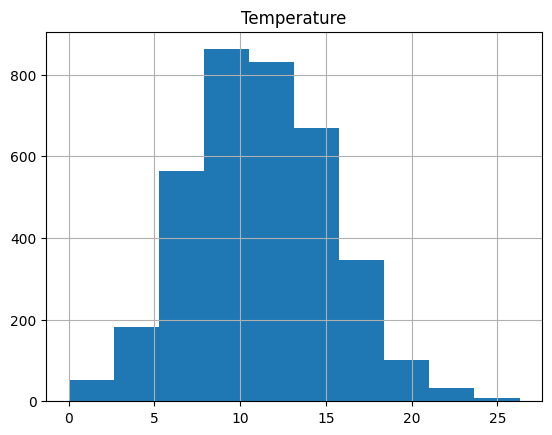

In [33]:
series.hist()

<Axes: ylabel='Density'>

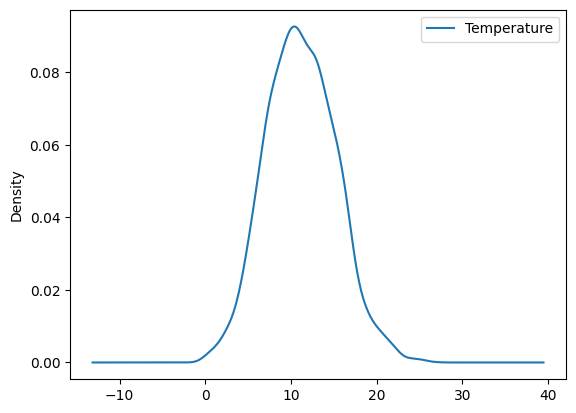

In [34]:
series.plot(kind='kde')

### Boxplots

<Axes: >

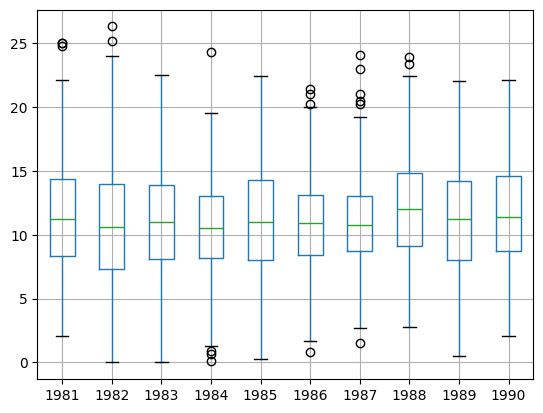

In [35]:
years.boxplot()

What if we want to see the distribution of values across months within a year...

<Axes: >

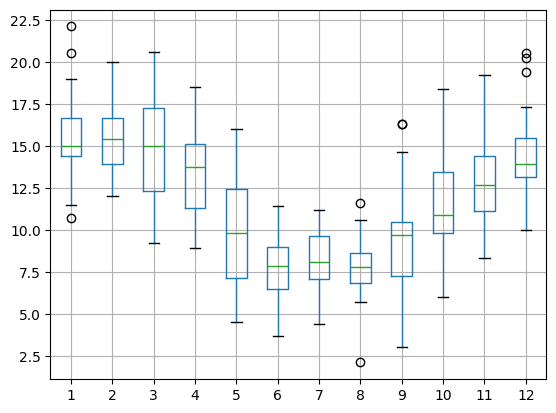

In [36]:
one_year = series.loc[series.index>='1990']
groups = one_year.groupby(pd.Grouper(freq='ME'))
months =pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()

### Heat maps
* A matrix of numbers can be plotted as a surface, where the values in each cell of the matrix are assigned a unique color --> heatmap

In [37]:
years.T

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
1981,20.7,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,...,15.0,12.8,15.0,14.2,14.0,15.5,13.3,15.6,15.2,17.4
1982,17.0,15.0,13.5,15.2,13.0,12.5,14.1,14.8,16.2,15.8,...,10.8,15.6,15.3,13.9,13.0,15.3,16.3,15.8,17.7,16.3
1983,18.4,15.0,10.9,11.4,14.8,12.1,12.8,16.2,15.5,13.0,...,12.2,16.7,13.8,17.5,15.0,13.9,11.1,16.1,20.4,18.0
1984,19.5,17.1,17.1,12.0,11.0,16.3,16.1,13.0,13.4,15.2,...,14.2,11.4,13.7,16.5,12.8,12.2,12.0,12.6,16.0,16.4
1985,13.3,15.2,13.1,12.7,14.6,11.0,13.2,12.2,14.4,13.7,...,13.7,12.0,13.1,13.2,13.3,11.5,10.8,12.0,16.3,14.4
1986,12.9,13.8,10.6,12.6,13.7,12.6,13.1,15.4,11.9,13.8,...,11.6,9.7,13.4,10.5,14.7,14.6,14.2,13.2,11.7,17.2
1987,12.3,13.8,15.3,15.6,16.2,16.3,16.8,11.0,8.5,13.2,...,11.2,11.4,11.2,12.1,12.7,16.2,14.2,14.3,13.3,16.7
1988,15.3,14.3,13.5,15.0,13.6,15.2,17.0,18.7,16.5,17.4,...,11.9,15.2,17.3,19.8,15.8,9.5,12.9,12.9,14.8,14.1
1989,14.3,17.4,18.5,16.8,11.5,9.5,12.2,15.7,16.3,13.6,...,11.8,12.0,12.7,16.4,16.0,13.3,11.7,10.4,14.4,12.7
1990,14.8,13.3,15.6,14.5,14.3,15.3,16.4,14.8,17.4,18.8,...,13.2,13.9,10.0,12.9,14.6,14.0,13.6,13.5,15.7,13.0


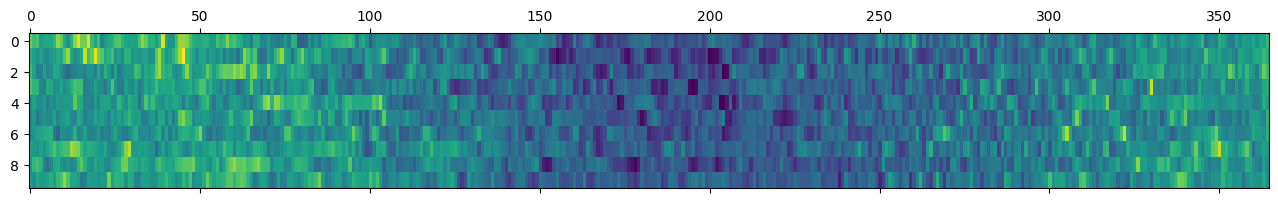

In [38]:
import matplotlib.pyplot as plt
plt.matshow(years.T, interpolation=None, aspect='auto')

### Lag Scatter Plots

* Time series modeling assumes a relationship between an observation and the previous observation
* Previous observations are called lags
* We can observe the relationship between each observation and a lag of that observation using a scatter plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

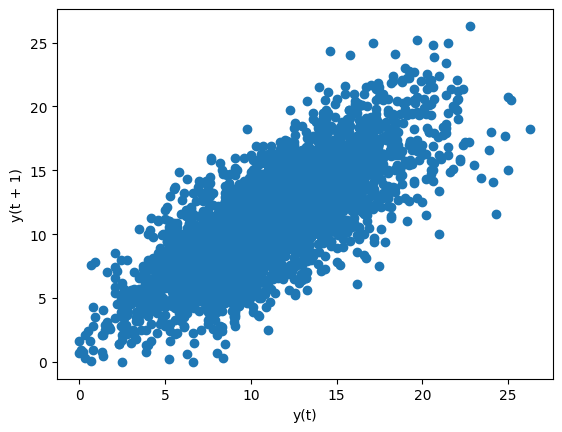

In [39]:
pd.plotting.lag_plot(series)

What other lag scatterplots would be intersting?

## Sliding Window

Imagine that we have a dataset like:

```
time, measures
1,    100
2,    110
3,    108
4,    115
5,    120
```
We can do using previous time steps as input variables and use the next time step as the output variable.

```
X,      y
?,      100
100,    110
110,    108
108,    115
115,    120
120,    ?
```

* We can see that the previous time step is the input (X) and the next time step is the output (y)
* The order between the observations is preserved
* we have no previous value that we can use to predict the first value

```
X,      y
100,    110
110,    108
108,    115
115,    120
```


## Rolling Window Statistics

* We can calculate summary statistics across the values in the sliding window and include these features in our dataset



In [40]:
series

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [41]:
temps = pd.DataFrame(series.values)
shifted = temps.shift(1)

window = shifted.rolling(window=2)

means = window.mean()

dataframe = pd.concat([means, temps], axis=1)
dataframe.columns = ['mean(t-1, t)', 'obs']

dataframe

,"mean(t-1, t)",obs
0,NaN,20.7
1,NaN,17.9
2,19.30,18.8
3,18.35,14.6
4,16.70,15.8
...,...,...
3645,13.75,14.0
3646,14.30,13.6
3647,13.80,13.5
3648,13.55,15.7


In [42]:
temps = pd.DataFrame(series.values)
width = 3

shifted = temps.shift(width-1)
window = shifted.rolling(window=width)

dataframe = pd.concat([window.min(), window.mean(), window.max(), temps], axis=1)
dataframe.columns = ['min', 'mean', 'max', 'obs']

dataframe.head(10)

,min,mean,max,obs
0,NaN,NaN,NaN,20.7
1,NaN,NaN,NaN,17.9
2,NaN,NaN,NaN,18.8
3,NaN,NaN,NaN,14.6
4,17.9,19.133333,20.7,15.8
5,14.6,17.100000,18.8,15.8
6,14.6,16.400000,18.8,15.8
7,14.6,15.400000,15.8,17.4
8,15.8,15.800000,15.8,21.8
9,15.8,16.333333,17.4,20.0


## Practice

* Explore [this dataset](https://www.kaggle.com/datasets/bulentsiyah/for-simple-exercises-time-series-forecasting/data)
* Create some visualizations
* Do you see any interesting patterns?

## Anúncios

* Vou abrir no moodle consulta mas o exame deve ser dia 24/05
* Vou abrir a agenda para apresentação remota do projeto de ICD